# Fake News Detection
Using NLP (tf-idf), Machine Learning and Deep Learning

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle

from collections import Counter
from unicodedata import category

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_df = pd.read_csv("train.csv").dropna()
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


0 means **reliable/real news**, 1 means **unreliable/fake news**

We will only perform predictions based on the **TEXT**

In [3]:
features, labels = train_df["text"], train_df.iloc[:, -1]
features.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    Ever get the feeling your life circles the rou...
2    Why the Truth Might Get You Fired October 29, ...
3    Videos 15 Civilians Killed In Single US Airstr...
4    Print \nAn Iranian woman has been sentenced to...
Name: text, dtype: object

In [4]:
features.info()

<class 'pandas.core.series.Series'>
Int64Index: 18285 entries, 0 to 20799
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
18285 non-null  object
dtypes: object(1)
memory usage: 285.7+ KB


In [5]:
labels.value_counts() #checking for invalid labels

0    10361
1     7924
Name: label, dtype: int64

Base probability is around 57%

### Visualising word distribution
For real and fake news

In [6]:
real = features.loc[train_df.label==0]
fake = features.loc[train_df.label==1]

In [7]:
fake.head()

0     House Dem Aide: We Didn’t Even See Comey’s Let...
2     Why the Truth Might Get You Fired October 29, ...
3     Videos 15 Civilians Killed In Single US Airstr...
4     Print \nAn Iranian woman has been sentenced to...
12    The mystery surrounding The Third Reich and Na...
Name: text, dtype: object

In [8]:
real = " ".join(real).split(" ")
fake = " ".join(fake).split(" ")

real_wordcount = Counter(real)
fake_wordcount = Counter(fake)

common_words = fake_wordcount.most_common(20)
common_words

[('the', 285342),
 ('of', 149697),
 ('to', 149394),
 ('and', 133635),
 ('a', 104173),
 ('in', 90524),
 ('that', 69757),
 ('is', 67517),
 ('for', 46152),
 ('on', 37121),
 ('with', 33032),
 ('are', 32293),
 ('as', 32264),
 ('be', 28730),
 ('by', 27732),
 ('was', 27680),
 ('have', 26630),
 ('it', 26527),
 ('not', 23047),
 ('this', 22662)]

Most common words appear to be stopwords like "the", "that", etc.

We'll use the `ntlk` library to remove them.

In [9]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.sort()
stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [10]:
for word, count in common_words:
    if word not in stopwords:
        print(f'{word} not in stopwords.')

### Filtering out stopwords

In [11]:
fake = Counter(filter(lambda x: x.lower() not in stopwords, fake))
real = Counter(filter(lambda x: x.lower() not in stopwords, real))

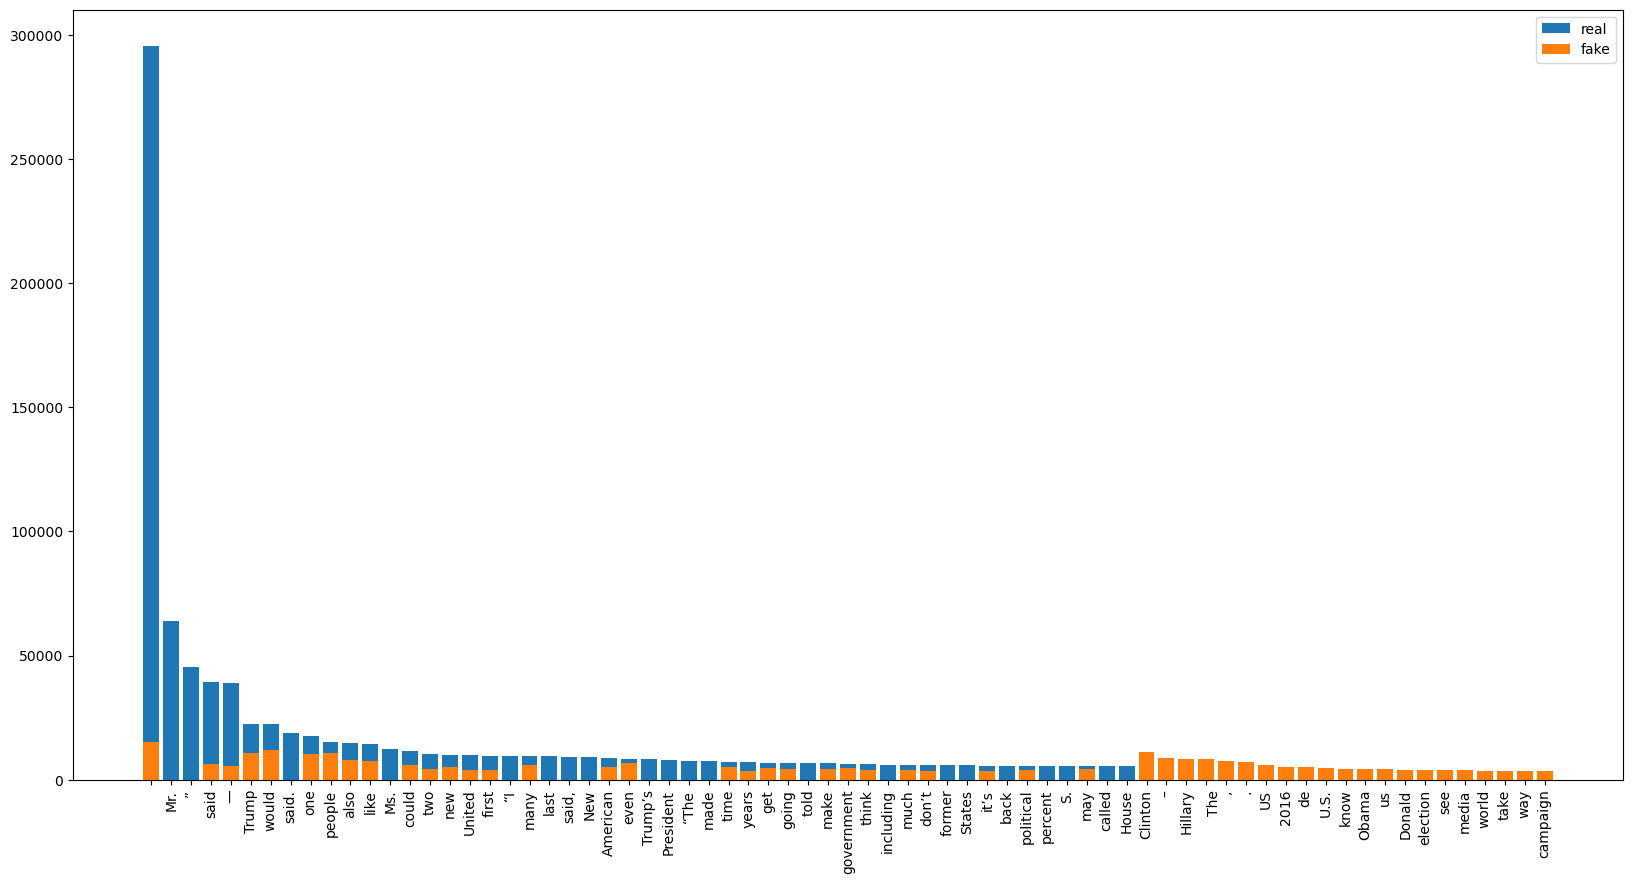

In [12]:
plt.figure(figsize=(20, 10))


plt.bar([word[0] for word in real.most_common(50)], 
        [word[1] for word in real.most_common(50)],
        label="real")


plt.bar([word[0] for word in fake.most_common(50)], 
        [word[1] for word in fake.most_common(50)],
        label="fake")

plt.xticks(rotation=90)

plt.legend()
plt.show()

## Filtering the text
Removing punctuations and stopwords

In [13]:
category(" "), category('"'), category("-"), category("/")

('Zs', 'Po', 'Pd', 'Po')

In [14]:
text_data = []
for text in features:
    text = text.split(" ")
    text_data.append(text)

In [15]:
def filter_text(text_samples):
    """Removes stopwords and punctuations from text"""
    filtered_text = []
    for text in text_samples:
        
        #1. remove blanks, newline characters and stopwords
        text_sw_removed = [word.lower().strip("\n") for word in text if word.lower().strip("\n") not in stopwords and word != ""]
        
        #2. remove punctuations
        filtered_sample = ["".join(char for char in word if category(char)[0] not in ["Z", "P"]) for word in text_sw_removed]
        filtered_text.append(filtered_sample)
        
    return filtered_text

In [16]:
filtered_text = filter_text(text_data)
print("Before filtering: ")
print(text_data[0])
print()
print("After filtering: ")
print(filtered_text[0])

Before filtering: 
['House', 'Dem', 'Aide:', 'We', 'Didn’t', 'Even', 'See', 'Comey’s', 'Letter', 'Until', 'Jason', 'Chaffetz', 'Tweeted', 'It', 'By', 'Darrell', 'Lucus', 'on', 'October', '30,', '2016', 'Subscribe', 'Jason', 'Chaffetz', 'on', 'the', 'stump', 'in', 'American', 'Fork,', 'Utah', '(', 'image', 'courtesy', 'Michael', 'Jolley,', 'available', 'under', 'a', 'Creative', 'Commons-BY', 'license)', '\nWith', 'apologies', 'to', 'Keith', 'Olbermann,', 'there', 'is', 'no', 'doubt', 'who', 'the', 'Worst', 'Person', 'in', 'The', 'World', 'is', 'this', 'week–FBI', 'Director', 'James', 'Comey.', 'But', 'according', 'to', 'a', 'House', 'Democratic', 'aide,', 'it', 'looks', 'like', 'we', 'also', 'know', 'who', 'the', 'second-worst', 'person', 'is', 'as', 'well.', 'It', 'turns', 'out', 'that', 'when', 'Comey', 'sent', 'his', 'now-infamous', 'letter', 'announcing', 'that', 'the', 'FBI', 'was', 'looking', 'into', 'emails', 'that', 'may', 'be', 'related', 'to', 'Hillary', 'Clinton’s', 'email', 

Now...let's remove the empty array elements

In [17]:
def remove_blank(text_sample):
    """
    Removes all empty array elements
    Args:
        text_sample: list of str
        
    Returns:
        cleaned_text: list of str
    """
    return [word for word in text_sample if word != ""]

In [18]:
for idx, text_sample in enumerate(filtered_text):
    filtered_text[idx] = remove_blank(text_sample)
    
# checking
print(f'Successful: {"" not in filtered_text[0]}')

Successful: True


## Applying a Lemmatizer
Words like "him" and "he" that share the same root ('lemma') will be 'merged' as one.

In [19]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_data = []
for text in filtered_text:
    lemmatized_text = " ".join([lemmatizer.lemmatize(word) for word in text])
    lemmatized_data.append(lemmatized_text)

In [20]:
lemmatized_data[0]

'house dem aide didnt even see comeys letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonsby license apology keith olbermann doubt worst person world weekfbi director james comey according house democratic aide look like also know secondworst person well turn comey sent nowinfamous letter announcing fbi looking email may related hillary clinton email server ranking democrat relevant committee didnt hear comey found via tweet one republican committee chairman know comey notified republican chairman democratic ranking member house intelligence judiciary oversight committee agency reviewing email recently discovered order see contained classified information long letter went out oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed me the fbi learned existence email appear pertinent investigation case reopened jason chaffetz jasonintheho

## Converting text to numbers
Vectorizing the text and applying Tf-Idf

In [21]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(lemmatized_data)
X_train.shape

(18285, 177324)

## Creating the Classifiers
We will use the Random Forest Classifier

## Training and testing models

In [2]:
train_df = pd.read_csv("train.csv")
train_df = train_df.dropna(subset=["text", "label"])

X, y = train_df.text, train_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
def preprocess(X):
        """
        Applies preprocessing steps to data
        
        Args:
            X: N*D matrix of training features
            
        Returns:
            X_processed: N*D matrix of processed training features
        """
        X_processed = []
        stopwords = nltk.corpus.stopwords.words("english")
        lemmatizer = nltk.stem.WordNetLemmatizer()
        
        for text in X:
            text = text.split(" ")
            
            #remove stopwords
            text_removed_sw = [word for word in text if word not in stopwords]
            
            #remove punctuations
            text_removed_punc = ["".join(char for char in word if category(char)[0] not in ["P", "Z"]) for word in text_removed_sw]
            
            #remove blanks
            text_processed = [word for word in text_removed_punc if word != ""]
            
            #lemmatize words
            text_lemmatized = [lemmatizer.lemmatize(word) for word in text_processed]
            
            #append to X_processed
            
            X_processed.append(" ".join(text_lemmatized))
            
        return X_processed

In [4]:
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_processed)
X_train_processed = vectorizer.transform(X_train_processed)
X_test_processed = vectorizer.transform(X_test_processed)

In [22]:
rf = RandomForestClassifier()

In [23]:
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

In [24]:
y_rf = rf.predict(X_test_processed)

In [25]:
print(f'Accuracy for Random Forest Classifier: {metrics.accuracy_score(y_test, y_rf)*100:.4f}%.')

Accuracy for Random Forest Classifier: 91.6520%.


## Testing other ML models
SVMs (try to beat the Random Forest 91.4272% test accuracy)

In [19]:
svm = SVC()
svm.fit(X_train_processed, y_train)
y_pred = svm.predict(X_test_processed)
accuracy_svm = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy for SVM: {accuracy_svm*100:.4f}%.')

Accuracy for SVM: 96.4842%.


## Saving the ML Models

In [26]:
pickle.dump(rf, open("RandomForest", "wb"))
pickle.dump(svm, open("SVM", "wb"))